In [1]:
%%capture
import os
import time
import datetime
import numpy as np
import pandas as pd
import xarray as xr

In [2]:
ARGO_DIR = '/data/datos/ARGO/data/'
argo_files = [os.path.join(ARGO_DIR,x) for x in os.listdir(ARGO_DIR) if x.endswith('_prof.nc')]

In [3]:
def get_hist(file, lats, lons):
    data = xr.open_dataset(file)
    mask = (data.LATITUDE < lats[0]) & (data.LATITUDE > lats[1]) & (data.LONGITUDE > lons[0]) & (data.LONGITUDE < lons[1])
    lat = data.LATITUDE[mask].data
    lon = data.LONGITUDE[mask].data
    pfid = data.PLATFORM_NUMBER.load()[mask].data.astype(int)
    stack = np.stack([lat,lon,pfid],axis=1)
    date = pd.to_datetime(data.JULD[0].data).date()
    return pd.DataFrame(stack, index = [np.repeat(date,len(stack))], columns=['lat','lon','pfid'])

In [4]:
ninodf = [get_hist(data_file,[0,-10],[-90,-80]) for data_file in argo_files[-30:]]
ninodf = pd.concat(ninodf)
ninodf.head()

,lat,lon,pfid
2019-01-08,-3.83503,-84.86370,3901266.0
2019-01-08,-3.46235,-86.48364,3901262.0
2019-01-10,-5.41400,-85.08700,6902809.0
2019-01-10,-6.97000,-87.98000,3901184.0
2019-01-11,-8.02600,-82.29800,6902665.0


In [74]:
data = ninodf.reset_index()
data = data.iloc[np.where(np.datetime64(datetime.date.today())-data['level_0']<np.timedelta64(10,'D'))]
data

,level_0,lat,lon,pfid
25,2019-01-28,-4.68299,-84.28687,3901266.0
26,2019-01-28,-3.04847,-85.81747,3901262.0
27,2019-01-30,-5.60700,-85.07200,6902809.0
28,2019-01-30,-7.21500,-87.83800,3901184.0
29,2019-01-31,-8.18800,-82.24200,6902665.0
30,2019-02-02,-1.34214,-88.19684,3901233.0
31,2019-02-02,-4.55400,-84.21043,3901266.0
32,2019-02-02,-2.92985,-85.96074,3901262.0
33,2019-02-03,-4.09023,-81.53523,3901231.0
34,2019-02-04,-8.22924,-87.86843,3901002.0


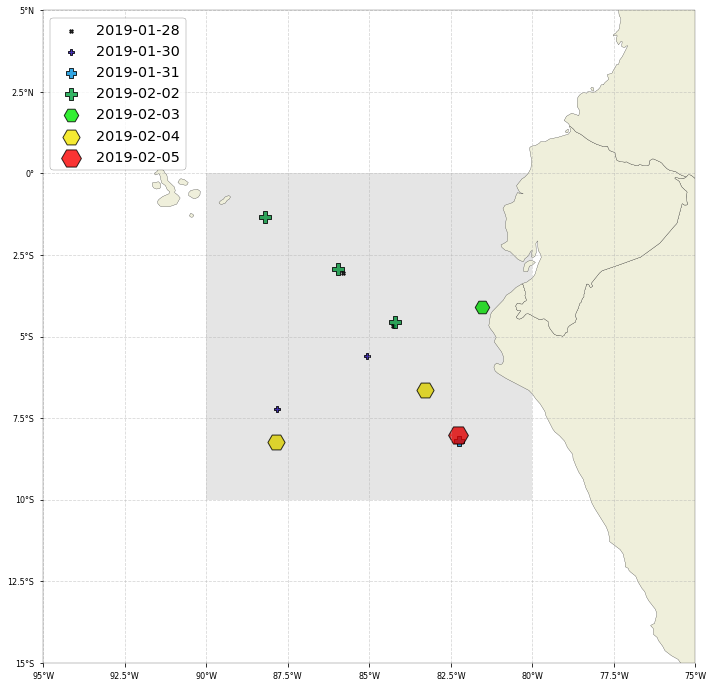

In [79]:
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import matplotlib.cm as cmx
import itertools
import cartopy.feature as cfeature
plt.style.use('seaborn-paper')

proj = ccrs.PlateCarree(central_longitude=180)
fig, ax = plt.subplots(subplot_kw=dict(projection=proj),figsize=(24,12))
ax.set_xticks(np.arange(0,360,2.5), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90,90,2.5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

ax.add_patch(mpatches.Rectangle(xy=[-90, -10], width=10, height=10,
                                    facecolor='black',
                                    alpha=0.1,
                                    transform=ccrs.PlateCarree()))
ax.grid(alpha=0.5,ls='--')

hq_border = cfeature.NaturalEarthFeature(
                            category='cultural',
                            name='admin_0_countries',
                            scale='50m',
                            facecolor=cfeature.COLORS['land'],
                            edgecolor='black')
ax.add_feature(hq_border)
ax.set_extent([85, 105, -15, 5], crs=proj)

uniq = list(set(data['level_0']))
uniq.sort()
z = range(1,len(uniq))
hot = plt.get_cmap('nipy_spectral')
cNorm  = colors.Normalize(vmin=0, vmax=len(uniq))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)

for i in range(len(uniq)):
    indx = data['level_0'] == uniq[i]
    if (i < 4) & (i>=1):
        mar = 'P'
    elif i<1:
        mar = 'X'
    else:
        mar = 'H'
    ax.scatter(data['lon'][indx], data['lat'][indx], s=(i+2)*(i+1)*len(uniq),marker = mar,alpha=0.8,color=scalarMap.to_rgba(i), edgecolor='k',lw=1,transform=ccrs.PlateCarree(), label=uniq[i].date())
ax.legend(loc='upper left',fontsize='x-large',frameon=True, fancybox=True, edgecolor='k')
# ax.gridlines(crs=ccrs.PlateCarree(), linewidth=2, color='black', alpha=0.5, linestyle='--', draw_labels=False)
# cbar = plt.colorbar(draw, ticks = np.arange(np.min(H),np.max(H),10))
# cbar.ax.tick_params(labelsize=15)  ro, nara, amaril ,cel ,azul
fig.savefig('/home/grivera/GitLab/argo/Notebooks/Output/last10days_argo.png',dpi=400,bbox_inches='tight')

In [105]:
x_grid = np.linspace(-90, -80, 4)
y_grid = np.linspace(-10, 0, 4)
H, xedges, yedges =np.histogram2d(ninodf['lon'], ninodf['lat'], bins=(x_grid, y_grid))
H = H.T

In [143]:
def get_hist(dataf):
    H, xedges, yedges =np.histogram2d(dataf['lon'], dataf['lat'], bins=(x_grid, y_grid))
    H = H.T.flatten()
    return pd.Series(data=H,index=np.arange(1,10))

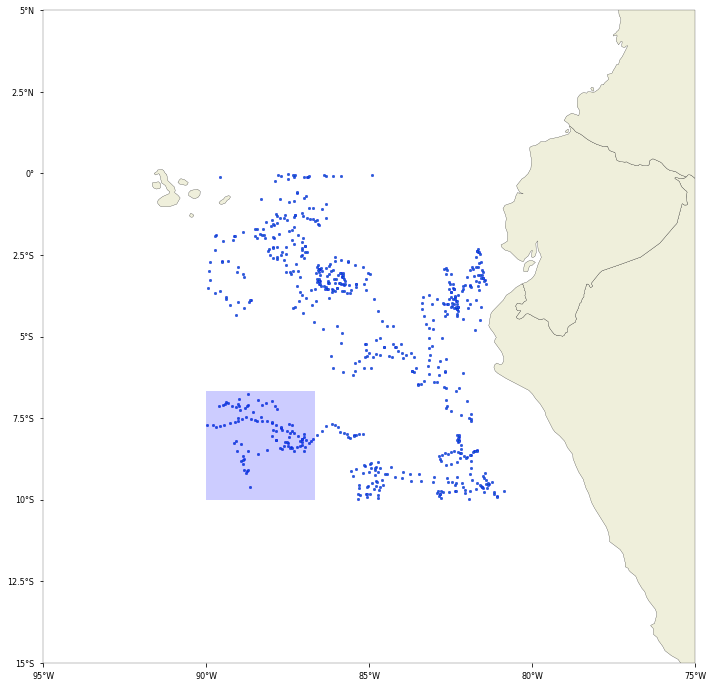

In [134]:
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.feature as cfeature
plt.style.use('seaborn-paper')

proj = ccrs.PlateCarree(central_longitude=180)
fig, ax = plt.subplots(subplot_kw=dict(projection=proj),figsize=(24,12))
ax.set_xticks(np.arange(0,360,5), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90,90,2.5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

ax.add_patch(mpatches.Rectangle(xy=[x_grid[0], y_grid[0]], width=x_grid[1]-x_grid[0], height=y_grid[1]-y_grid[0],
                                    facecolor='blue',
                                    alpha=0.2,
                                    transform=ccrs.PlateCarree()))

hq_border = cfeature.NaturalEarthFeature(
                            category='cultural',
                            name='admin_0_countries',
                            scale='50m',
                            facecolor=cfeature.COLORS['land'],
                            edgecolor='black')
ax.add_feature(hq_border)
ax.set_extent([85, 105, -15, 5], crs=proj)

draw = ax.scatter(ninodf['lon'], ninodf['lat'], s=6,edgecolor='b',lw=0.4,transform=ccrs.PlateCarree(),cmap=plt.get_cmap('GnBu'))
# cbar = plt.colorbar(draw, ticks = np.arange(np.min(H),np.max(H),10))
# cbar.ax.tick_params(labelsize=15) 

In [130]:
H

array([[101.,  65.,  97.],
       [ 24.,  90.,  86.],
       [112.,  59.,  34.]])

In [127]:
H.flatten().shape

(9,)

In [145]:
new_hist = ninodf.groupby(ninodf.index).apply(get_hist)
new_hist.head()

,1,2,3,4,5,6,7,8,9
2018-01-28,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2018-01-30,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2018-01-31,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0
2018-02-01,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2018-02-02,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


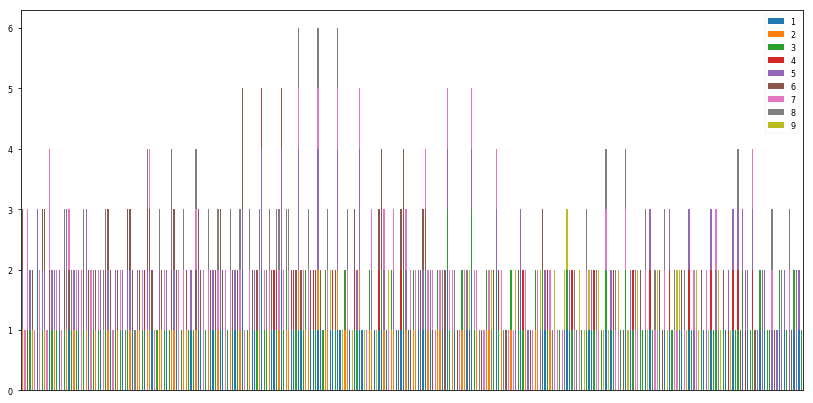

In [193]:
import matplotlib.ticker as mticker
import matplotlib.dates as mdates

df = new_hist
fig, ax = plt.subplots(figsize=(14,7))
df.plot.bar(stacked = True, ax=ax)
# ax.xaxis_date()
# ax.set_xticklabels(df.index.strftime('%Y-%m'))
ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
# fig.autofmt_xdate()
# new_hist.iloc[-20:].plot.bar(stacked = True)